# Data Visualization for Qwen Models

Found results directory: ../llm_results/qwen_no_reasoning
Processing files in ../llm_results/qwen_no_reasoning...

Aggregated Results:
    model_size model_name  shots  Accuracy  Precision (Accept)  \
1          1.5  Qwen 1.5B      0  0.709171            0.554340   
0          1.5  Qwen 1.5B      1  0.652114            0.458451   
10         1.5  Qwen 1.5B      2  0.383884            0.333082   
11         1.5  Qwen 1.5B      3  0.615512            0.430370   
6          3.0    Qwen 3B      0  0.707519            0.529336   
7          3.0    Qwen 3B      1  0.702107            0.769231   
13         3.0    Qwen 3B      2  0.475895            0.367245   
12         3.0    Qwen 3B      3  0.711255            0.767974   
15         7.0    Qwen 7B      0  0.661388            0.475711   
14         7.0    Qwen 7B      1  0.766699            0.644717   
4          7.0    Qwen 7B      2  0.651653            0.467251   
5          7.0    Qwen 7B      3  0.751619            0.671161   
3      

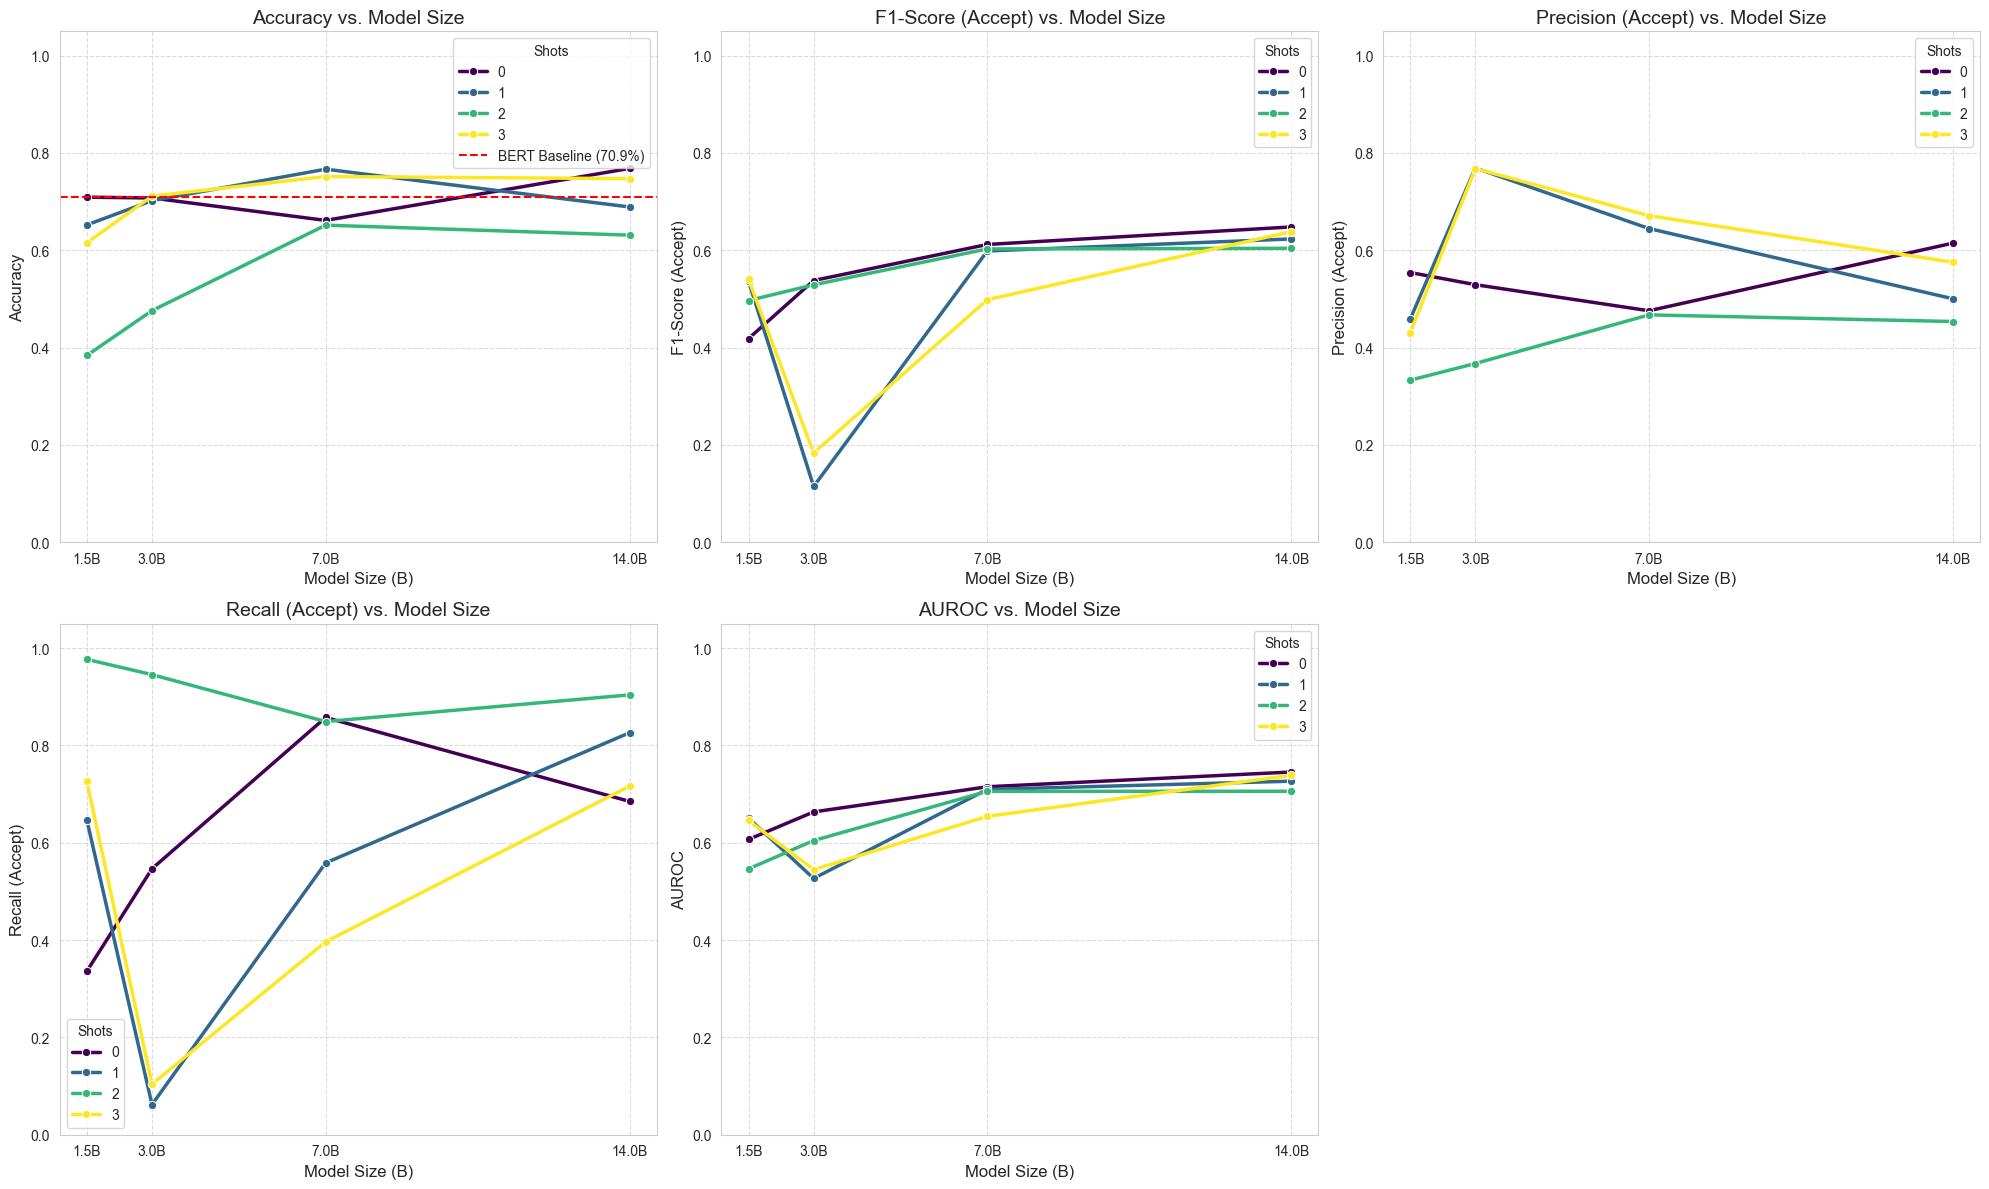

In [48]:

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def parse_prediction(response):
    """
    Parses the model response to extract the decision.
    Prioritizes <decision> tags, then falls back to keyword search.
    Returns 1 for Accept, 0 for Reject, and None if undetermined.
    """
    if not isinstance(response, str):
        return 0 # Treat as reject or failure
        
    # Try extracting from <decision> tags
    match = re.search(r"<decision>\s*(.*?)\s*</decision>", response, re.DOTALL | re.IGNORECASE)
    if match:
        content = match.group(1).strip().lower()
        if "accept" in content:
            return 1
        if "reject" in content:
            return 0
            
    # Fallback: Keyword search in the whole text
    response_lower = response.lower()
    if "accept" in response_lower and "reject" not in response_lower:
        return 1
    if "reject" in response_lower and "accept" not in response_lower:
        return 0
        
    # Ambiguous case: check if it starts with one
    if response_lower.startswith("accept"):
        return 1
    if response_lower.startswith("reject"):
        return 0
        
    return 0 # Default to Reject if unclear (conservative)

def analyze_qwen_results(results_dir=None, bert_baseline_acc=0.709):
    
    # Potential paths
    potential_paths = [
        '../llm_results/qwen_no_reasoning',
        'llm_results/qwen_no_reasoning',
        '/Users/samanthamallari/Desktop/FALL25/ICS691/llm-aspr/llm_results/qwen_no_reasoning'
    ]
    
    if results_dir:
        potential_paths.insert(0, results_dir)
        
    valid_dir = None
    for path in potential_paths:
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.json')]
            if files:
                valid_dir = path
                print(f"Found results directory: {valid_dir}")
                break
    
    if not valid_dir:
        print("Error: Could not find results directory.")
        return

    results_dir = valid_dir
    model_data = []
    
    print(f"Processing files in {results_dir}...")
    
    for filename in os.listdir(results_dir):
        if filename.endswith('.json'):
            # Parse filename: qwen_{size}_{shots}shot.json
            match = re.search(r'qwen_(.*?)_(\d+)shot', filename)
            if match:
                model_size_str = match.group(1)
                shots = int(match.group(2))
                
                try:
                    with open(os.path.join(results_dir, filename), 'r') as f:
                        data = json.load(f)
                        
                    results = data.get('results', [])
                    if not results:
                        continue
                        
                    y_true = []
                    y_pred = []
                    
                    for r in results:
                        # Ground Truth
                        gt_str = r.get('ground_truth', '').lower()
                        if 'accept' in gt_str:
                            y_true.append(1)
                        else:
                            y_true.append(0)
                            
                        # Prediction
                        resp = r.get('model_response', '')
                        pred = parse_prediction(resp)
                        y_pred.append(pred)
                    
                    # Calculate metrics
                    acc = accuracy_score(y_true, y_pred)
                    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
                    
                    try:
                        auroc = roc_auc_score(y_true, y_pred)
                    except ValueError:
                        auroc = 0.5 # Default if only one class present
                    
                    # Convert size to float for sorting
                    try:
                        size_val = float(model_size_str.replace('B', '').replace('b', ''))
                    except:
                        size_val = 0
                        
                    model_data.append({
                        'model_size': size_val,
                        'model_name': f"Qwen {model_size_str}",
                        'shots': shots,
                        'Accuracy': acc,
                        'Precision (Accept)': precision,
                        'Recall (Accept)': recall,
                        'F1-Score (Accept)': f1,
                        'AUROC': auroc
                    })
                    
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

    if not model_data:
        print("No data found.")
        return

    df = pd.DataFrame(model_data)
    df = df.sort_values(by=['model_size', 'shots'])
    
    print("\nAggregated Results:")
    print(df)
    
    # Plotting
    metrics = ['Accuracy', 'F1-Score (Accept)', 'Precision (Accept)', 'Recall (Accept)', 'AUROC']
    
    # Setup 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    unique_sizes = sorted(df['model_size'].unique())
    xtick_labels = [f"{s}B" for s in unique_sizes]
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(x='model_size', y=metric, hue='shots', data=df, 
                     marker='o', palette='viridis', linewidth=2.5, ax=ax)
        
        ax.set_title(f'{metric} vs. Model Size', fontsize=14)
        ax.set_xlabel('Model Size (B)', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_xticks(unique_sizes)
        ax.set_xticklabels(xtick_labels)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylim(0, 1.05)
        
        # Add BERT baseline to Accuracy plot
        if metric == 'Accuracy' and bert_baseline_acc:
            ax.axhline(y=bert_baseline_acc, color='red', linestyle='--', label=f'BERT Baseline ({bert_baseline_acc:.1%})')
            
        ax.legend(title='Shots')

    # Hide the last empty subplot if we have 5 metrics and 6 slots
    if len(metrics) < len(axes):
        for j in range(len(metrics), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
    return df

# Run the analysis
df_results = analyze_qwen_results()

# save to csv
df_results.to_csv('qwen_results.csv', index=False)
